Quick notebook to highlight the segmentation performance of the model.

How illustrative it is is debatable, since the model is used to the segmentation line being in the center of the chip. A better illustration would be to keep that line in the center and vary the image instead.

In [11]:
import pathlib

data_path = pathlib.Path('/data/road_surface_classifier')
assert data_path.is_dir()

imagery_path = data_path / 'imagery'
assert imagery_path.is_dir()

masks_path = data_path / 'masks'
assert masks_path.is_dir()

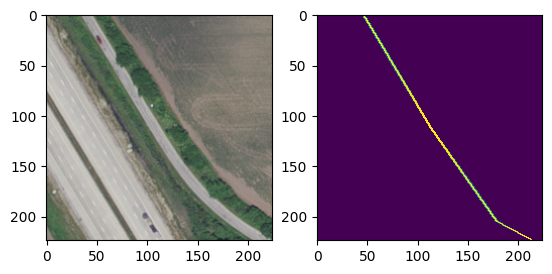

In [14]:
import numpy as np
import PIL.Image
import matplotlib.pyplot as plt

osm_id =  '5329089' # '5702347'

this_img_path = imagery_path / f'{osm_id}.tif'
img = PIL.Image.open(this_img_path)
img = np.array(img)[16:240, 16:240, :]

this_mask_path = masks_path / f'{osm_id}.png'
mask = PIL.Image.open(this_mask_path)
mask = np.array(mask)[16:240, 16:240, np.newaxis]

fig, ax = plt.subplots(1, 2)
ax[0].imshow(img[..., (0, 1, 2)])  # RGB
ax[1].imshow(mask)



In [15]:
import torch
from rsc.artifacts import find_best_model, device

# Load model in
results_path = data_path / 'results' / '20230514_011657Z'
assert results_path.is_dir()

model = torch.load(results_path / 'model.pth').load_from_checkpoint(find_best_model(results_path))
model.to(device)
model.eval()


PLMaskCNN(
  (transform): DataAugmentation(
    (transform_flip): Sequential(
      (0): RandomHorizontalFlip(p=0.5, p_batch=1.0, same_on_batch=False)
      (1): RandomVerticalFlip(p=0.5, p_batch=1.0, same_on_batch=False)
    )
    (transform_offset): Sequential(
      (0): RandomAffine(degrees=(-15, 15), translate=(0.0625, 0.0625), scale=None, shear=None, p=0.5, p_batch=1.0, same_on_batch=False, resample=bilinear, padding_mode=zeros, align_corners=False)
    )
    (transform_color): Sequential(
      (0): RandomPlasmaBrightness(roughness=(0.1, 0.5), intensity=(0.1, 0.3), p=0.5, p_batch=1.0, same_on_batch=False)
      (1): ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1, p=1.0, p_batch=1.0, same_on_batch=False)
    )
    (transform_nir): Sequential(
      (0): ColorJitterNoHueSat(brightness=0.1, contrast=0.1, saturation=0.0, hue=0.0, p=1.0, p_batch=1.0, same_on_batch=False)
    )
  )
  (loss): MCNNLoss(
    (hxe_loss): RSCHXELoss()
    (o_loss): BCEWithLogitsLoss()
  

In [16]:
import PIL.Image
import PIL.ImageDraw

def inf_image(img, mask):
    x = np.concatenate((img / 255., mask / 255.), axis=-1)
    x = np.moveaxis(x, -1, 0)[np.newaxis, ...]
    y, _ = model(torch.Tensor(x).to(device))
    y = y.cpu().detach().numpy()
    return y[0, 0, ...]

def draw_line(img, x1, y1, x2, y2):
    img = PIL.Image.fromarray(img)
    PIL.ImageDraw.Draw(img).line([(x1, y1), (x2, y2)], fill=255, width=2)
    return np.array(img)[..., np.newaxis]


all_masks_in = np.zeros((224, 224, 256), dtype=np.uint8)
all_masks_out = np.zeros((224, 224, 256))
for i in range(256):
    # theta = 2 * np.pi * (i / 256)
    l = 64
    # _x1, _y1 = 128 - l * np.sin(theta), 128 - l * np.cos(theta)
    # _x2, _y2 = 128 + l * np.sin(theta), 128 + l * np.cos(theta)

    offset = 64 + 16 - ((112 + 32) * i) / 224
    theta = np.pi / 4 - np.pi / 16
    _x1, _y1 = (112 - l * np.sin(theta)) + offset , (112 - l * np.cos(theta)) - offset
    _x2, _y2 = (112 + l * np.sin(theta)) + offset , (112 + l * np.cos(theta)) - offset

    mask_in = draw_line(np.zeros((224, 224), dtype=np.uint8), _x1, _y1, _x2, _y2)
    mask_out = inf_image(img, mask_in)
    all_masks_in[:, :, i] = mask_in[..., 0]
    all_masks_out[:, :, i] = mask_out


In [17]:
%matplotlib widget
import matplotlib.animation as animation

mask = np.zeros((256, 256, 1), dtype=np.uint8)

fig, ax = plt.subplots(1, 3, sharex=True, figsize=(12, 4))
fig.tight_layout()
for _ax in ax:
    _ax.xaxis.set_visible(False)
    _ax.yaxis.set_visible(False)
ax[0].imshow(img[..., (0, 1, 2)])
ax[1].imshow(img[..., (0, 1, 2)])
ax[2].imshow(img[..., (0, 1, 2)])
ax_1 = ax[1].imshow(all_masks_in[:, :, 0], cmap='magma', alpha=0.5)
ax_2 = ax[2].imshow(all_masks_out[:, :, 0], cmap='magma', alpha=0.5)

def animate(i):
    ax_1.set_array(all_masks_in[:, :, i])
    ax_2.set_array(all_masks_out[:, :, i])
    return ax


anim = animation.FuncAnimation(fig, animate, frames=256, interval=60, blit=True, repeat=True)
from IPython import display
video = anim.to_html5_video()
plt.close('all')
display.HTML(video)